<a href="https://colab.research.google.com/github/cbeluzo/dev/blob/master/EDA_SIVEP_Malaria_treatment_schemas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA SIVEP-Malaria: Treatment Schemas

#### This notebook performs EDA focusing on treatment schemas

<a id='imports'></a>
### Imports

In [1]:
! pip install shap lime synapseclient

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import lime
import math
import seaborn as sns

import zipfile as zp
import synapseclient as syna
from getpass import getpass

from lime import lime_tabular

from termcolor import colored
from datetime import datetime

import itertools

import plotly as pty
import plotly.express as px

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<a id='loading_dataset'></a>
## Load dataset

In [3]:
 # Getting BD from Synapse
 syn = syna.Synapse() 
 syn.login(input('Sybapse User: '), getpass('Passwd:')) 
 
 # Obtain a pointer and download the data
 # sivep_completo.csv.zip - https://www.synapse.org/#!Synapse:syn24225699
 dataset = syn.get(entity='syn25713874')
 
 # Get the path to the local copy of the data file 
 filepath = dataset.path

 with zp.ZipFile(filepath,"r") as zip_ref:
    zip_ref.extractall("")


Sybapse User: cbeluzo
Passwd:··········
Welcome, Carlos Eduardo Beluzo!



Adicionei low_memory=False, por causa do warning de dtype

In [4]:
df_full = pd.read_csv('./dados/sivep_data.csv', sep=';', low_memory=False, encoding="ISO-8859-1")
df_full.shape

(3737123, 51)

In [5]:
df_full.head()

,ï»¿uid,ano,cod_noti,dt_notif,dt_envlo,dt_digit,sem_noti,tipo_lam,uf_notif,mun_noti,...,niv_esco,id_pacie_anos,nu_predi_infe,nu_habit_infe,zona_infe,categori_infe,nu_predi_resi,nu_habit_resi,zona_resi,categori_resi
0,1,2007,1,2007-01-02,2011-03-23,2007-01-03,1.0,Detecção Passiva,AC,120042,...,Não se aplica,6,85.0,201.0,Rural,Ramal,85.0,201.0,Rural,Ramal
1,2,2007,2,2007-01-02,2011-03-23,2007-01-03,1.0,Detecção Passiva,AC,120042,...,Não se aplica,2,85.0,201.0,Rural,Ramal,85.0,201.0,Rural,Ramal
2,3,2007,14,2007-01-02,2011-03-23,2007-01-03,1.0,Detecção Passiva,AC,120042,...,Analfabeto,47,85.0,201.0,Rural,Ramal,85.0,201.0,Rural,Ramal
3,4,2007,18,2007-01-02,2011-03-23,2007-01-03,1.0,Detecção Passiva,AC,120042,...,5ª a 8ª série incompleta do EF,15,85.0,201.0,Rural,Ramal,85.0,201.0,Rural,Ramal
4,5,2007,24,2007-01-02,2011-03-23,2007-01-06,1.0,Detecção Passiva,AC,120042,...,5ª a 8ª série incompleta do EF,22,85.0,201.0,Rural,Ramal,85.0,201.0,Rural,Ramal


## Data Preprocessing

In [6]:
df_prep = df_full.copy()

In [7]:
df_prep.columns

Index(['ï»¿uid', 'ano', 'cod_noti', 'dt_notif', 'dt_envlo', 'dt_digit',
       'sem_noti', 'tipo_lam', 'uf_notif', 'mun_noti', 'cod_unin', 'cod_agen',
       'dt_nasci', 'id_pacie', 'id_dimea', 'sexo', 'raca', 'pais_res',
       'uf_resid', 'mun_resi', 'loc_resi', 'sintomas', 'dt_sinto', 'cod_ocup',
       'uf_infec', 'pais_inf', 'mun_infe', 'loc_infe', 'dt_exame', 'res_exam',
       'qtd_para', 'qtd_cruz', 'dt_trata', 'esquema', 'hemoparasi', 'exame',
       'examinador', 'id_lvc', 'gestante', 'vivax', 'falciparum', 'niv_esco',
       'id_pacie_anos', 'nu_predi_infe', 'nu_habit_infe', 'zona_infe',
       'categori_infe', 'nu_predi_resi', 'nu_habit_resi', 'zona_resi',
       'categori_resi'],
      dtype='object')

**Convert date columns to datetime datatype**

In [8]:
date_cols = ['dt_sinto', 'dt_notif', 'dt_exame', 'dt_trata']
df_prep[date_cols] = df_prep[date_cols].apply(pd.to_datetime,  errors='coerce')
df_prep[date_cols].head()

,dt_sinto,dt_notif,dt_exame,dt_trata
0,2007-01-01,2007-01-02,2007-01-02,2007-07-02
1,2007-01-02,2007-01-02,2007-01-02,2007-07-02
2,2007-01-01,2007-01-02,2007-01-02,2007-01-02
3,2006-12-30,2007-01-02,2007-01-02,2007-01-02
4,2007-01-02,2007-01-02,2007-01-03,2007-01-03


#### Feature values domain

In [9]:
cols = df_prep.columns
for col in cols:
    print(col, ": ", df_prep[col].dtype)
    print(df_prep[col].unique(), "\n")

ï»¿uid :  int64
[      1       2       3 ... 3737121 3737122 3737123] 

ano :  int64
[2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020] 

cod_noti :  int64
[     1      2     14 ... 178117 178222 179036] 

dt_notif :  datetime64[ns]
['2007-01-02T00:00:00.000000000' '2007-01-04T00:00:00.000000000'
 '2007-01-05T00:00:00.000000000' ... '2020-06-13T00:00:00.000000000'
 '2020-06-14T00:00:00.000000000' '2020-06-16T00:00:00.000000000'] 

dt_envlo :  object
['2011-03-23' '2011-08-03' '2011-11-03' ... '2020-03-08' '2020-03-21'
 '2020-02-22'] 

dt_digit :  object
['2007-01-03' '2007-01-06' '2007-01-09' ... '2020-03-21' '2020-02-22'
 '2020-06-06'] 

sem_noti :  float64
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 30. 26. 31. 27. 33. 32. 28. 29. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. nan] 

tipo_lam :  object
['Detecção Passiva' 'LVC (ficha antiga)' 'Detecção Ativa'] 

uf_notif :

# EDA - Bivariabels

## Treament schemas per pregnat women

#### Distribuição absoluta dos esquemas de tratamento por idade gestacional.

In [ ]:
# Selecting interesting features
dfAux1 = df_prep[['esquema','gestante','ano', 'uf_notif','id_pacie_anos']]
dfAux1.rename(columns={"id_pacie_anos": "total"}, inplace=True)

# Agregating data and formating CSV file
dfAux1 = dfAux1.groupby(["ano","esquema","gestante","uf_notif"]).count()
dfAux1.to_csv("dados/gestante_X_esquema.csv")
dfAux1 = pd.read_csv('dados/gestante_X_esquema.csv', sep=',', low_memory=False)
dfAux1.head()

In [30]:
#import plotly.offline as pyo
#pyo.plot(fig, filename="2D_hist_gestante_X_esquema.html")

fig = px.density_heatmap(dfAux1.sample(frac=1), x="gestante", y="esquema", z="total", histfunc="sum", text_auto=True,  width=2500, height=1000)
fig.write_html("2D_hist_gestante_X_esquema.html")
fig.show(renderer="colab")

## Basic graphics: Treatment Schema X Gestational period

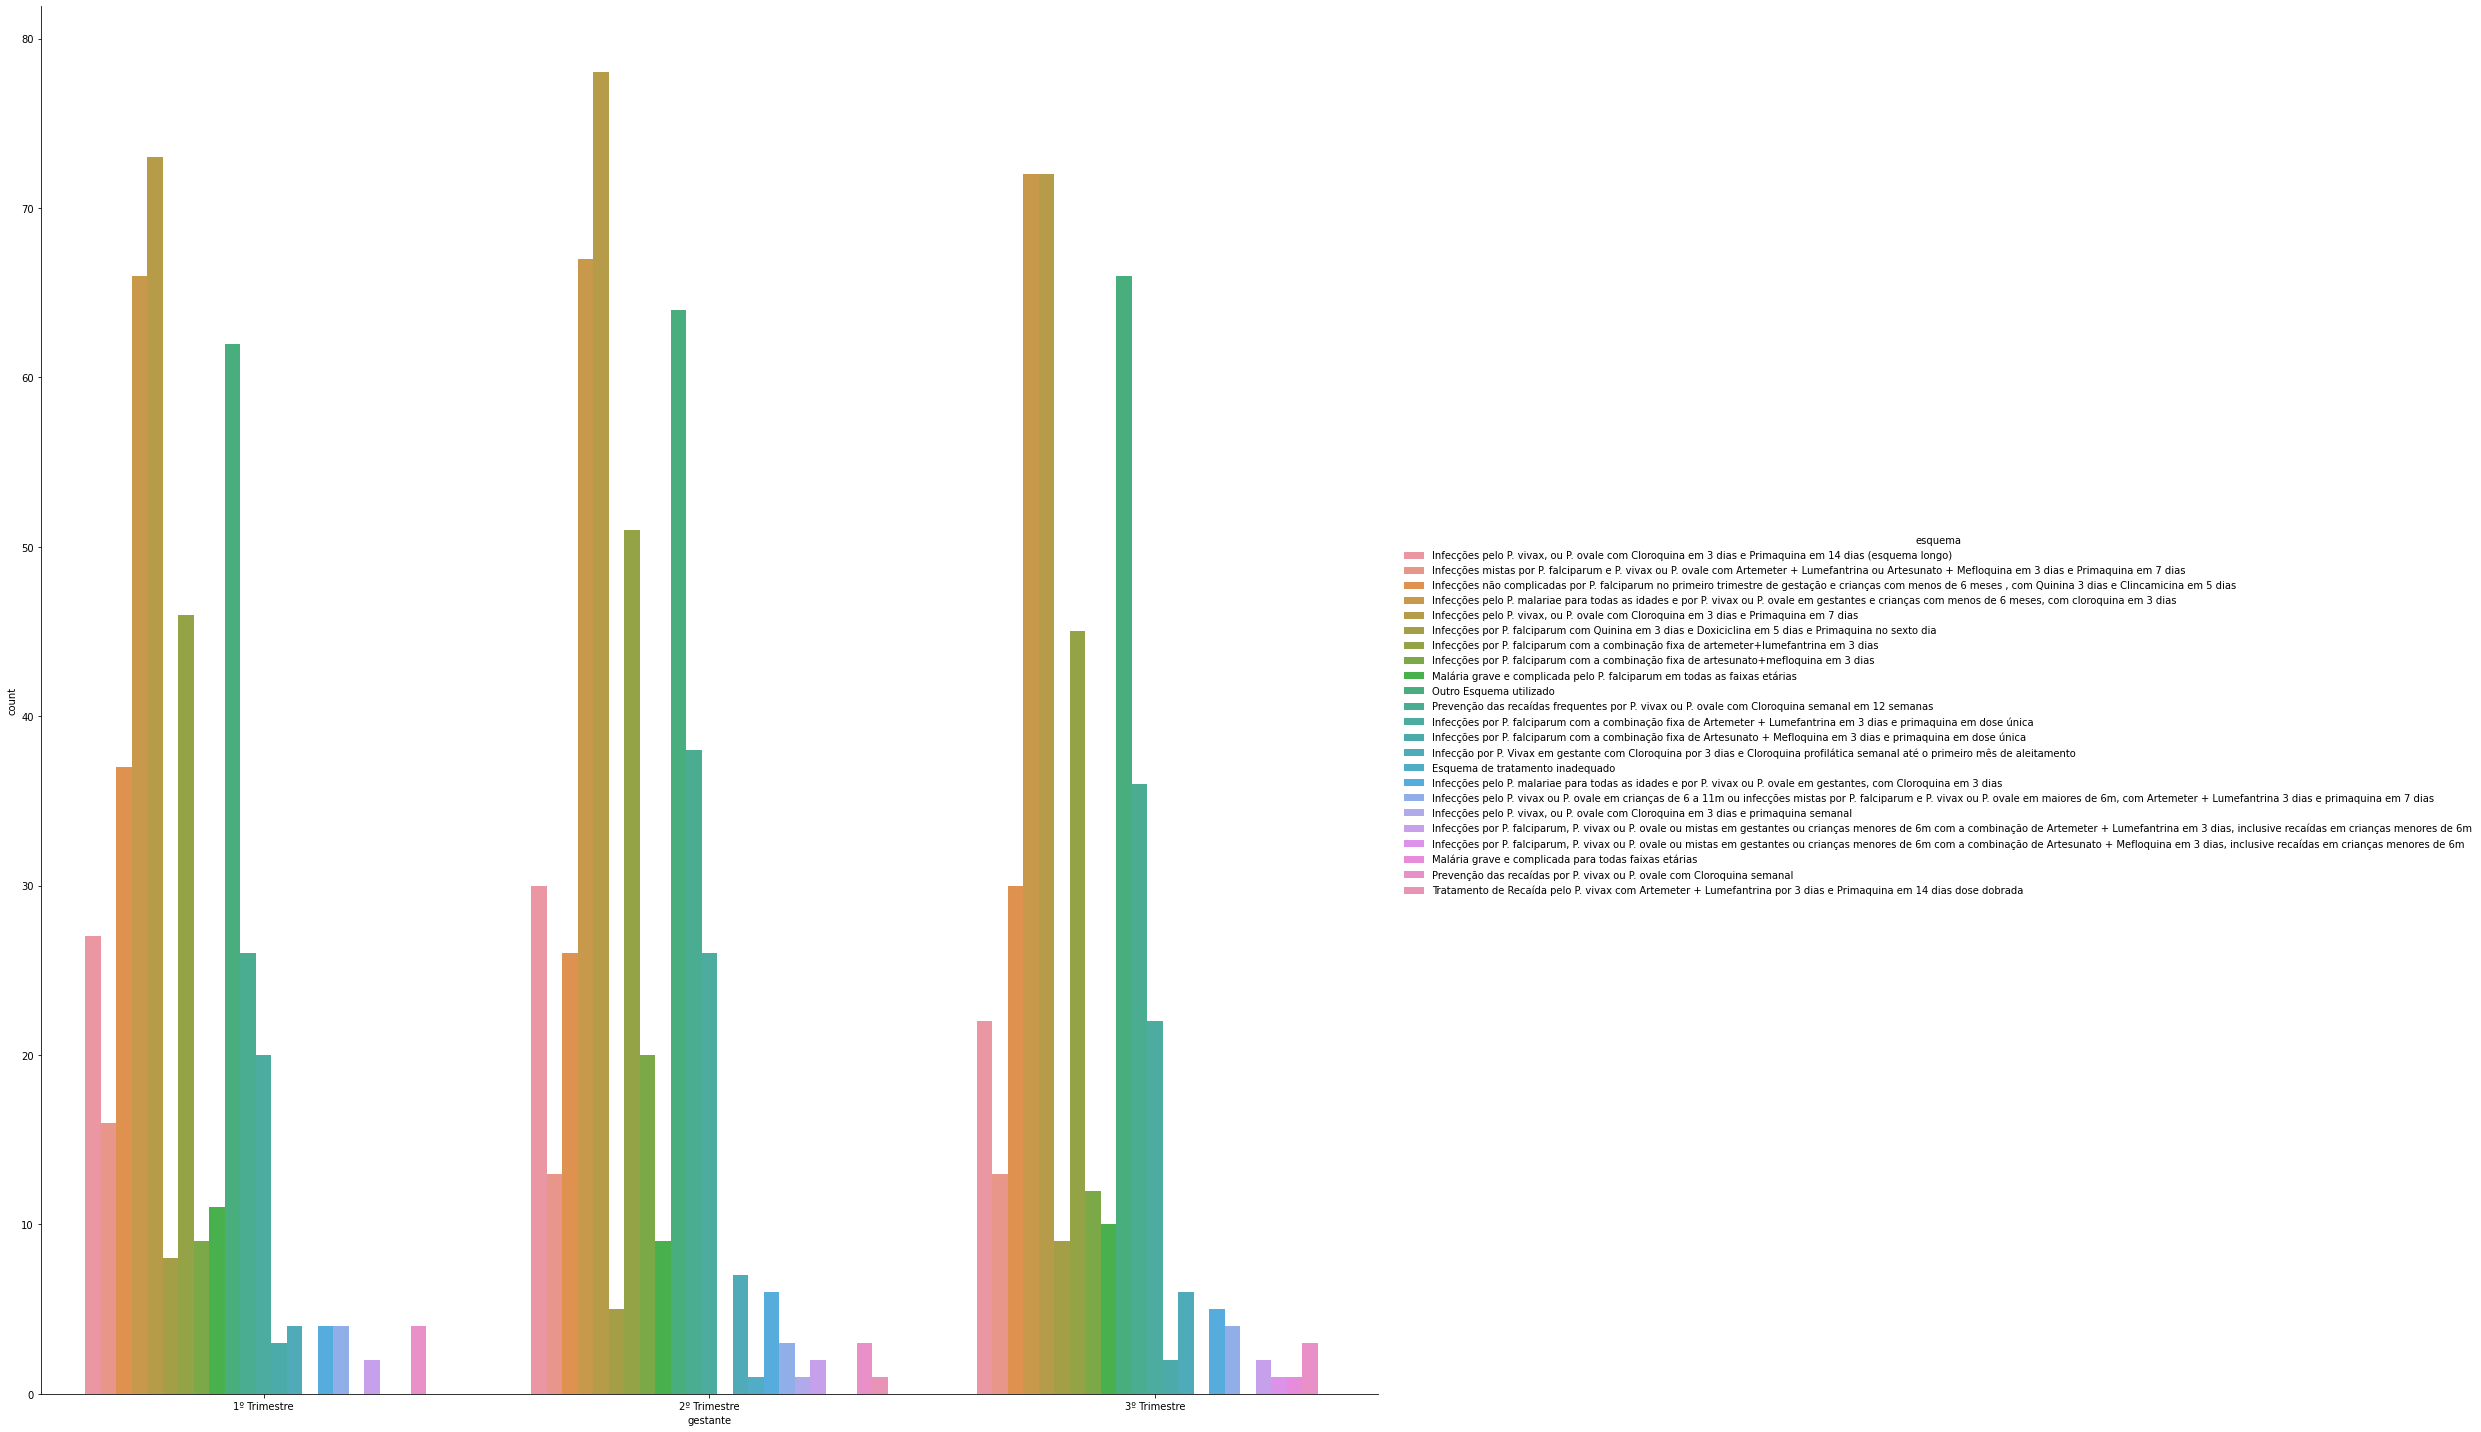

In [31]:
filter_list = ['2º Trimestre','3º Trimestre','1º Trimestre']
fig = sns.catplot(x="gestante", hue="esquema", kind="count", data=dfAux1.query("gestante == @filter_list"), height=20, aspect=1)
fig.savefig("Gestante_X_Esquema.png") 

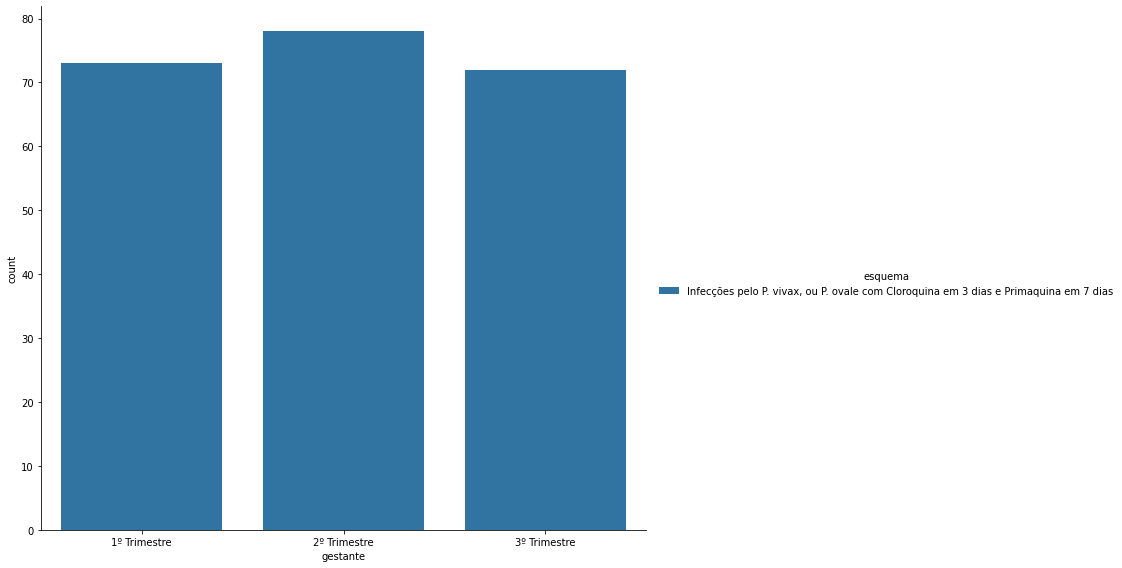

In [32]:
t11 = 'Infecções pelo P. vivax, ou P. ovale com Cloroquina em 3 dias e Primaquina em 7 dias'

fig = sns.catplot(x="gestante", hue="esquema", kind="count", data=dfAux1.query("gestante == @filter_list and esquema == @t11"), height=8, aspect=1.2)
fig.savefig("Gestante_X_Esquema11.png")

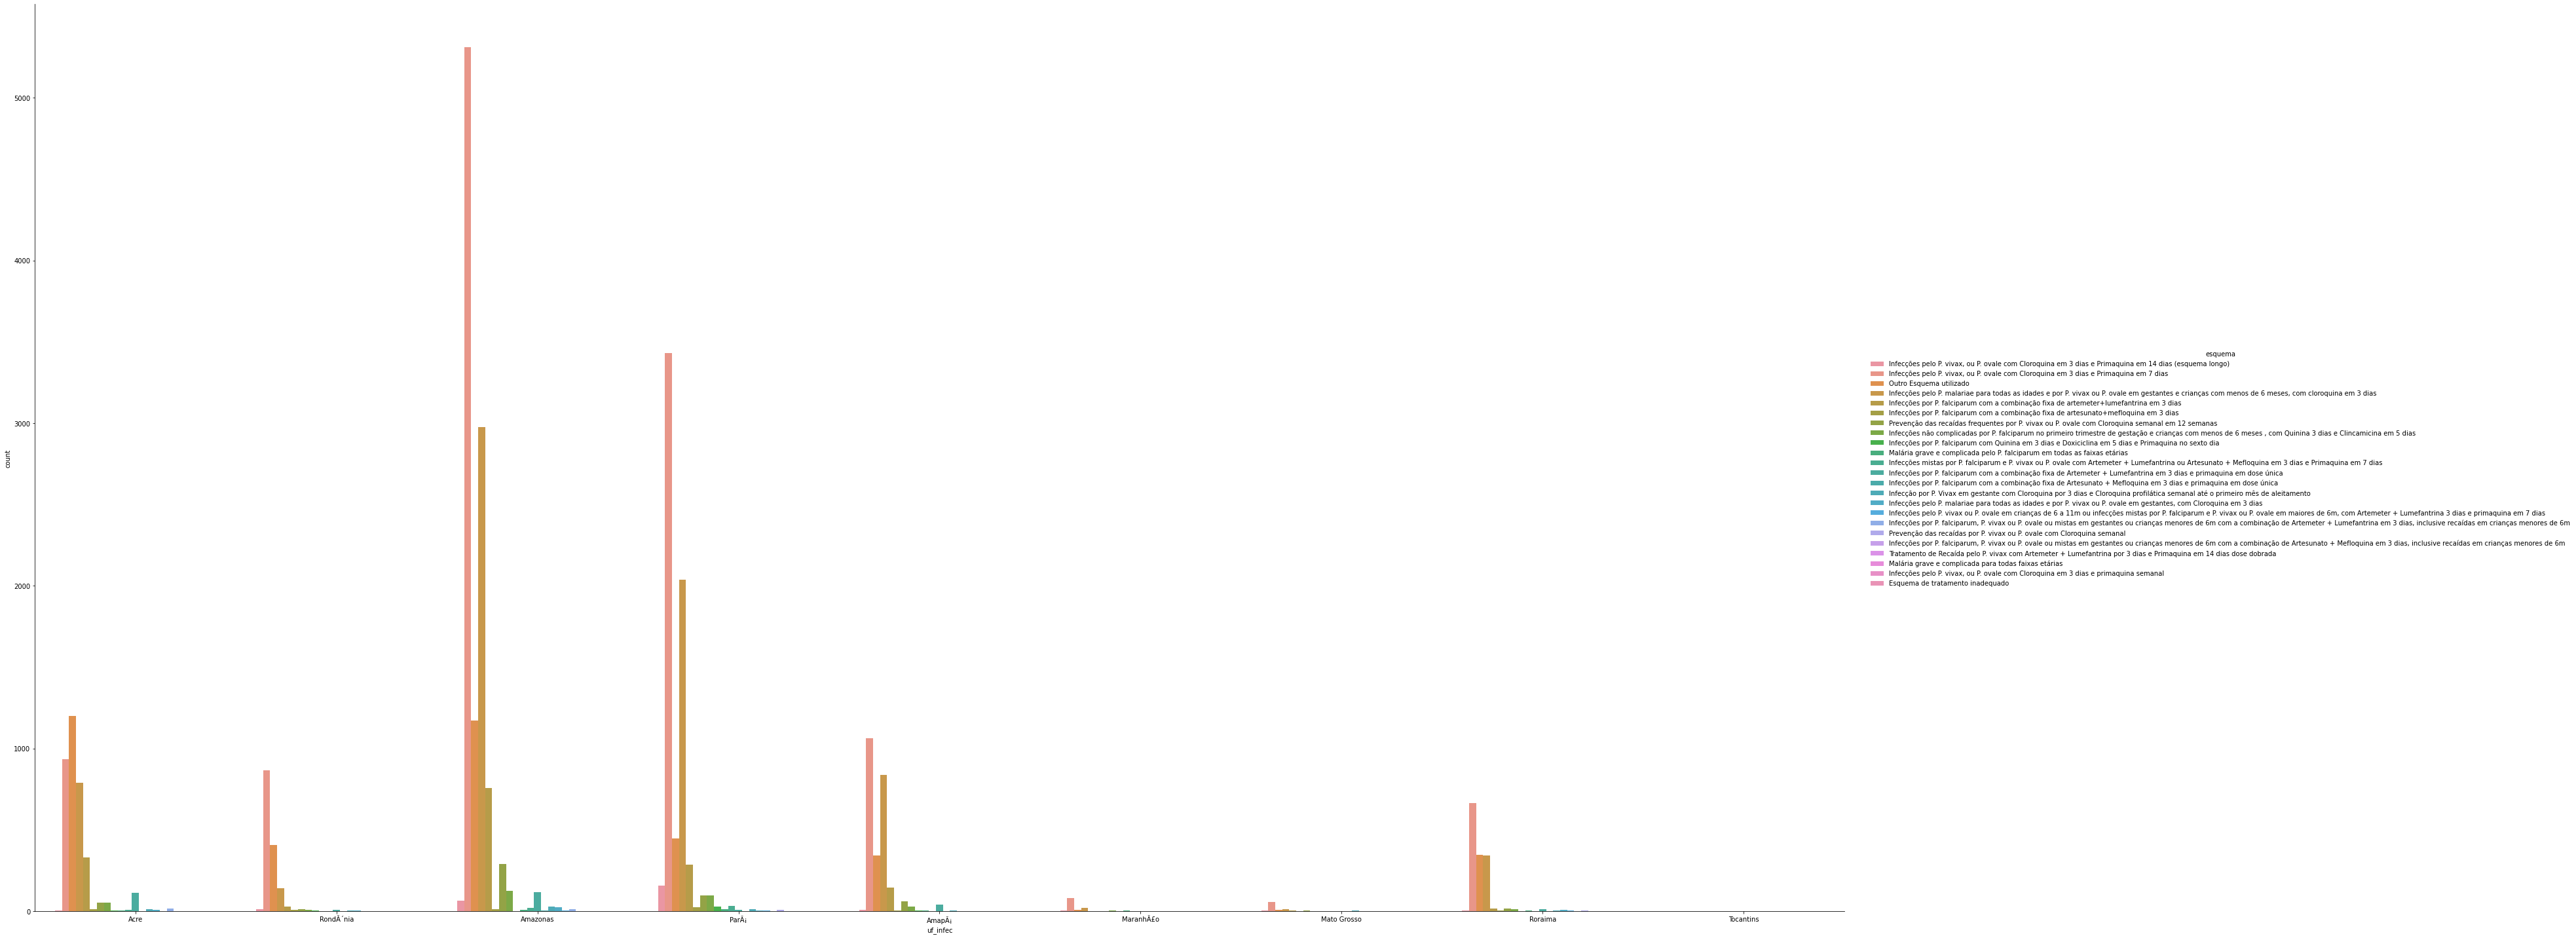

In [33]:
filter_list = ['2º Trimestre','3º Trimestre','1º Trimestre']

dfAux1 = df_prep[['esquema','gestante', 'uf_infec']]
dfAux1

fig = sns.catplot(x="uf_infec", hue="esquema", kind="count", data=dfAux1.query("gestante == @filter_list"), height=20, aspect=2)
fig.savefig("uf_infec_X_Esquema.png") 